# Трансформация датасетов: добавление новых колонок и расширенный анализ данных
В этом ноутбуке датафреймы дополняются новыми колонками, которые могут характеризовать успешность проекта, и производится вторичный анализ данных проекта.

**Содержание**
1. [Поиск идей по вторичным данным](#intermid_analysis)
2. [Загружаем библиотеки](#libs)
3. [Загружаем данные](#load_data)
4. [Преобразование и анализ основного датафрейма с протоколами](#protocols_dataframe_transformation)
5. [Преобразование и анализ датафрейма с организациями](#organizations_dataframe_transformation)
6. [Преобразование и анализ датафрейма с учителями](#teachers_dataframe_transformation)


___
<a id='intermid_analysis' name='intermid_analysis'></a>
## 1. Поиск идей по вторичным данным

#### Вторичные колонки на основе анализа времени проведения урока
- В рамках нашего проекта четко выделяются два периода — весна и осень 2022 года. Очевидно, что будет полезно  добавить колонку для указания периода, в который попадает протокол (весна - 1, осень - 2).
- Поле с датой кажется более интересным заменить полем, в котором будет храниться информация о том, сколько дней прошло с начала периода. Условно этой стартовой датой могут быть даты первого урока весны и первого урока осени соответственно.
- Для более наглядной статистики можно добавить еще одно поле, где фиксировать количество недель, прошедших с недели, когда был заполнен первый протокол текущего периода.
- **Интересный параметр** - это информация о том, сколько дней прошло с момента заполнения учителем предыдущего протокола. Для первого протокола периода (весны или осени) этот параметр может быть определен как NaN, а для всех остальных протоколов - как разница дней между текущим и предыдущим протоколами. Этот параметр позволит фиксировать ситуации, когда протоколы заполняются учителем с сильно меняющимися дельтами. Это может говорить о формальном отношении учителя или даже всей школы к проекту. Можно для сводной статистики по отдельному учителю на основании этих параметров фиксировать как среднее время интервалов между уроками, так и дисперсию этого параметра. В идеале дисперсия должна быть минимальной, по дисперсиям можно будет сравнивать и учителей, и организации.


#### Анализ данных из протоколов с информацией о группах учеников (сильные, средние, слабые)
В **усложненных** и **прицельных** протоколах, которые использовались в школах, присутствуют вопросы, которые позволяют оценивать как среднюю успешность учеников каждого класса, так и то, как распределяется внимание учителя при работе с каждой из групп. Важно отметить, что оценки уровня успешности каждого ученика весьма субъективны, и разные учителя, возможно, один и тот же класс оценивали бы по-разному. НО в контексте этого проекта точность оценок силы ученика не столь важна. Важно то, что один и тот же учитель не только оценивает уровень успешности ученика, но и фиксирует реальное количество взаимодействий с ним. Это позволяет построить систему оценки уровня распределения внимания учителя между учениками разных уровней успешности, основывающуюся не на абсолютных значениях, а на относительных.

Исходя из задач обучения мы считаем, что учитель изменил к лучшему качество своих уроков, если:
- большее количество учеников стали оказываться в зоне его внимания
- если распределение внимания учителя либо равномерное по ученикам разного уровня успешности, либо сместилось в сторону поддержки более слабых учеников.

Второй критерий не всегда может говорить о том, что школы, сместившие вектор внимания на сильных учеников, не правы - могут быть классы, в которых дети в целом успешны, и учитель вкладывает больше усилий в тех учеников, которые могут помочь школе повысить свой рейтинг благодаря успехам в олимпиадах и других мероприятиях, учитывающихся при подсчете рейтинга. Однако договоримся о том, что описанные выше критерии мы будем считать индикаторами успешного обучения, приведшего к изменениям в поведении учителя.

Предлагается использовать следующий подход к формированию метрик, которые позволят зафиксировать эти критерии.

В протоколах есть вопросы, часть из которых фиксирует количество **взаимодействий** с учениками, а есть вопросы, которые фиксируют **количество учеников**, с которыми учитель на уроке взаимодействовал. Первый тип вопросов сложно анализировать, потому что количество взаимодействий может зависеть от особенностей урока, выбранной формы работы учителя с учениками. На одном уроке взаимодействий может быть мало, и это нормально, а на другом - много, и это тоже нормально. Поэтому для формирования первого критерия мы будем анализировать соотношение между количеством учеников, которые присутствовали на урокен, и учениками, с которыми учитель взаимодействовал (независимо от их уровня). Будет хорошо, если осенью этот параметр для учителя оказался более высоким, чем весной. 

Таким образом, добавим в датасет с протоколами колонку - процент учеников в зоне внимания от общего количества присутствующих на уроке.

Для того, чтобы посчитать второй параметр, создадим промежуточные колонки для каждого из вопросов, который фиксировал параметры учеников с разными уровнями успеваемости. Эти колонки будут фиксировать среднюю успеваемость учеников класса и дисперсию успеваемости, фактически определяющую, насколько близка или отличается успеваемость учеников одного класса.

Рассмотрим эти дополнительные колонки и правила их подсчета для колонок, содержащих информацию о том, сколько сильных, средних и слабых учеников присутствовало на уроке. Аналогичным образом будут создаваться дополнительные колонки и для вопросов о количестве взаимодействий с учениками разных уровней, и для вопросов о количестве учеников разного уровня, с которыми взаимодействовал учитель. 

Итак, предположим, что на уроке было $Y_{1}$ сильных учеников, $Y_{2}$ средних учеников и $Y_{3}$ слабых учеников.  

Общее количество учеников в классе $Y = Y_{1} + Y_{2} + Y_{3}$.  

Будем считать среднюю успеваемость по формуле ([markdown formulas](https://medium.com/analytics-vidhya/writing-math-equations-in-jupyter-notebook-a-naive-introduction-a5ce87b9a214))

$${M} = \frac{Y_{1} + Y_{2}0.5 + Y_{3}}{Y}$$


Эта формула в своих крайних значениях даст следующие результаты:
- Если все ученики в классе сильные, М = 1. 
- Если все ученики - слабые, М = 0 
- Если все ученики средние - М = 0.5. 
- Если в классе половина сильных и половина слабых учеников, М = 0.5

Параметр, который будем считать дисперсией, будем вычислять по формуле:  
$$ D= \sqrt{\frac{Y_{1}(M-1)^2 + Y_{2}(M-0.5)^2 + Y_{3}(M-0)^2}{Y}}  $$

- Если все ученики в классе сильные, средние или слабые, $D=0$. 
- Если в классе поровну сильных, средних и слабых, $M=0.5$, а $D\approx 0.42$
- Если в классе половина учеников - сильная, а половина - слабая, $M=0.5$, а $D=0.5$
- Если в классе половина сильных и половина средних учеников, $M=0.75$, а $D=0.25$


Благодаря тому, что у нас появляется пара этих параметров, мы получаем возможность сравнивать распределение присутствующих на уроке учеников по успеваемости с распределением количества взаимодействий учителяс учениками разной успеваемости и с распределением количества учеников разного уровня, с которыми учитель взаимодействовал.

Важно при этом отметить, что можно ожидать стопроцентного охвата всех учеников в малокомплектных школах. Если на уроке присутствует всего 4-5 учеников, учитель почти наверняка успеет пообщаться с каждым из них.

Предположим, мы анализируем параметры конкретного протокола, в котором зафиксирована следующая информация:
- Количество учеников на уроке: сильные - 4, средние - 6, слабые - 8 ($M_{1.1}=0.39$, $D_{1.1}=0.39$)
- Количество взаимодействий на уроке: сильные - 5, средние - 8, слабые - 7 ($M_{1.2}=0.45$, $D_{1.2}=0.38$)
- Количество учеников, с которыми взаимодействовал учитель: сильные - 2, средние - 3, слабые - 6 ($M_{1.3}=0.31$, $D_{1.3}=0.38$)

Также предположим, что следующий протокол этого же учителя имел следующие параметры:
- Количество учеников на уроке: сильные - 3, средние - 8, слабые - 5 ($M_{2.1}=0.44$, $D_{2.1}=0.35$)
- Количество взаимодействий на уроке: сильные - 5, средние - 8, слабые - 3 ($M_{2.2}=0.56$, $D_{2.2}=0.35$)
- Количество учеников, с которыми взаимодействовал учитель: сильные - 2, средние - 6, слабые - 5 ($M_{2.3}=0.38$, $D_{2.3}=0.35$)

Как мы можем сравнить эти протоколы? Количество учеников в классах разное, распределение учеников по уровню - тоже разное.
Однако благодаря матожиданию мы видим, что на первом уроке - более слабый класс (0.39 < 0.44), при этом, сравнивая дисперсии, мы видим, что распределение учеников в классе по уровням на этих уроках похоже.

Что мы можем сказать о том, насколько равномерно распределялось внимание учителя между учениками разных уровней на первом уроке? Сравним параметры $M_{1.1}$ и $M_{1.3}$ для первого урока. Мы видим, $M_{1.1}=0.39$, $M_{1.3}=0.31$, т.е. $M_{1.1}>M_{1.3}$
Получается, что при существующем распределении учеников на уроке учитель чуть больше внимания уделял более слабым ученикам, чем более сильным, т.е. с точки зрения "хорошего" урока это - положительный результат!

Аналогично получаем для второго урока, что $M_{2.1}>M_{2.3}$

Если мы сравним также пары $M_{1.1}$ и $M_{1.2}$, а также $M_{2.1}$ и $M_{2.2}$, то тут ситуация - обратная. В обоих случаях учитель хотя и обратил внимание на бОльшее количество слабых учеников, общался во время урока больше с сильными учениками.

Рассмотрев эти примеры, мы можем увидеть, что для каждого протокола будет рациональным добавить три дополнительных параметра, каждый из которых будет показывать, куда направлен на уроке условный "вектор внимания" учителя. Это - дельты между $M_{1}$, $M_{2}$ и $M_{3}$

Добавим и эти колонки в датасет:
- $V_{1} = M_{1} - M_{2}$ - Назовем этот параметр Вектор взаимодействия. Если этот параметр больше нуля, то это означает, что учитель во время урока взаимодействовал с бОльшим количеством более слабых учеников. 
- $V_{2} = M_{1} - M_{3}$ - Назовем этот параметр Вектор намерения. Если этот параметр больше нуля, то это означает. что у учителя во время урока было больше взаимодействий с более слабыми учениками.
- $V_{3} = M_{2} - M_{3}$ - Назовем этот параметр Вектор внимания. Если этот параметр близок к нулю, можно считать, что учитель не только поставил задачу охватить во время урока своим вниманием определенные группы учеников, но и в течение всего урока сохранял пропорцию распределения своего внимания с учениками каждой из групп. Можно предположить, что если учитель на урок поставил себе задачу больше взаимодействовать с одной группой учеников, но подсознательно он более склонен к работе с другой группой, то из-за потери внимания во время урока он может неосознанно иногда смещать вектор своего внимания в сторону более комфортного для себя взаимодействия. Это - гипотеза, посмотрим, проявится ли это как-то на конкретных данных.


Как использовать параметр $D$, пока не очень понятно, но кажется полезным как минимум учитывать этот параметр как одну из характеристик распределения учеников разных уровней для присутствующих на уроке. Может быть, дальнейший анализ данных проекта позволит увидеть дополнительную ценность этого параметра. Тем не менее кажется очевидным, что чем ближе это параметр к нулю, тем менее надежными оказываются выше описанные методы измерения дельт между матожиданиями. Условно - если в классе присутствуют ученики, имеющие одинаковый уровень успеваемости, то кого бы и сколько бы учитель во время не спрашивал, $V_{i}$ будут стремиться к нулю. Для малокомплектных классов эта ситация может быть актуальной.


Указанные выше параметры могут считаться для каждого протокола.

Однако если готовить сводную статистику по каждому учителю, такие обобщенные параметры по всем протоколам можно считать не как среднее арифметическое этих параметров для всех протоколов учителя, а суммировать количества сильных, средних. слабых учеников по всем протоколам анализируемого периода (весны и осени) и вычислять матожидания и дисперсии относительно этих сумм. Это позволит получить более правдоподобные цифры в случае малокомплектных школ.

Аналогичный подход может быть использован и при вычислении этих обобщенных параметров на уровне школы. Могут быть проанализированы протоколы всех учителей этой школы и выведены средние значения этих параметров для школы как для весны, так и для осени.

Если для организации указанные параметры вычислены, появляется возможность сравнивать показатели каждого учителя со средними показателями по школе. Это позволит выявлять учителей, параметры которых отличаются от параметров его коллег.



#### Идеи на будущее (открытый список, который можно расширять по мере выполнения этого проекта)
- Теоретически можно также анализировать информацию о повторных использованиях одних и тех же протоколов. В частности интересно было бы "поймать" корреляцию между повторными обращениями к протоколу и ответам учителя на вопросы об удовлетворенности уроком и желании что-то изменить для более ранних уроков, на которых использовался повторяющийся протокол. Эту идею пока фиксирую скорее на будущее.


Ссылка для себя: ([markdown formulas](https://medium.com/analytics-vidhya/writing-math-equations-in-jupyter-notebook-a-naive-introduction-a5ce87b9a214))

In [1]:
# Вычисление M, D (Функция использовалась для вычисления примеров значений в предыдущей ячейке)
def calc_MD(pupils=[0,0,0]):
    M, D = 0, 0
    Y1, Y2, Y3 = pupils
    Y = Y1 + Y2 + Y3
    if (Y>0):
        M = (Y1 + Y2*0.5)/Y
        D = ((Y1*(M-1)**2 + Y2*(M-0.5)**2 + Y3*M**2)/Y)**0.5
    return M, D    

calc_MD([2,6,5])

(0.38461538461538464, 0.34828404377451605)

___
<a id='libs' name='libs'></a>
## 2. Загружаем библиотеки для работы с данными


In [2]:
%run "./lib/load_big_libs.py"

In [3]:
%run "./lib/data_lib.py"

___
<a id='load_data' name='load_data'></a>
## 3. Загружаем базовые датафреймы
*Функция get_core_dataframes загружена из файла /lib/data_lib.py*

In [4]:
df_templates, df_protocols = get_core_dataframes('gap')

# Сразу же проверяем данные о шаблонах
df_templates.head(20)

,code,id,title,group,level,protocols_df_name
0,П1.1,1,Базовый протокол «Распределение внимания учителя»,Распределение внимания учителя,1,protocols_1_1
1,П1.2,3,Усложненный протокол «Распределение внимания у...,Распределение внимания учителя,2,protocols_1_2
2,П1.3,2,Прицельный протокол «Распределение внимания уч...,Распределение внимания учителя,3,protocols_1_3
3,П2.1,4,Базовый протокол «Время на размышление»,Время на размышление,1,protocols_2_1
4,П2.2,6,Усложненный протокол «Время на размышление»,Время на размышление,2,protocols_2_2
5,П2.3,5,Прицельный протокол «Время на размышление»,Время на размышление,3,protocols_2_3
6,П3.1,7,Базовый протокол «Тип вопросов»,Тип вопросов,1,protocols_3_1
7,П3.2,9,Усложненный протокол «Тип вопросов»,Тип вопросов,2,protocols_3_2
8,П3.3,8,Прицельный протокол «Тип вопросов»,Тип вопросов,3,protocols_3_3
9,П4.1,10,Базовый протокол «Качество обратной связи»,Качество обратной связи,1,protocols_4_1


___
<a id='protocols_dataframe_transformation' name='protocols_dataframe_transformation'></a>
## 4. Дополним основной датасет с протоколами дополнительными колонками

#### По шаблонам протоколов
1. Добавим колонку **group** (7 групп, текстовое поле)  
2. Добавим колонку **level** (1, 2, 3, т.е. базовый, усложненный или прицельный)

#### По времени
1. Добавим колонку **period** (1 - весна, 2 - осень)  
2. Добавим колонку **day** (порядковый номер дня с даты первого урока, зафиксированного в системе)
3. Добавим колонку **day_of_period** (порядковый номер дня с даты первого урока, зафиксированного в системе для текущего периода - весна или осень)
4. Добавим колонку **interval** (nan для первого протокола учителя в текущем периоде или разница в днях текущего протокола и предыдущего)

#### По группам учеников 
1. Добавим колонку **scope** (отношение количества учеников, с которыми взаимодействовал учитель, к общему количеству учеников на уроке. nan если поля pupils_all или attention_all нулевые или равны nan, и attention_all/pupils_all в противном случае)
2. Добавим колонку **pupils_m** (матожидание среднего уровня учеников на уроке. Число от 0 до 1)
3. Добавим колонку **pupils_d** (дисперсия уровня учеников на уроке. Число от 0 до 1)
4. Добавим колонку **interactions_m**
5. Добавим колонку **interactions_d**
6. Добавим колонку **attention_m**
7. Добавим колонку **attention_d**
8. Добавим колонку **vector_interact** (Вектор взаимодействия - разница между pupils_m и interactions_m)
9. Добавим колонку **vector_intention** (Вектор намерения - разница между pupils_m и attention_m)
10. Добавим колонку **vector_attention** (Вектор внимания - разница между attention_m и interactions_m)


#### По шаблонам протоколов
Добавим две колонки, которые определяют группу и уровень протокола

In [5]:
df_protocols = df_protocols.join(df_templates[['code', 'group', 'level']].set_index('code'), on='template_code')

#### По времени
Вначале посмотрим, как распределяются протоколы по датам

In [6]:
import datetime
from datetime import date

In [7]:
# Будем считать дни с 1 января 2022 года
start_date = datetime.date(2022,1,1)
def calc_days(val):
    d_arr = [int(i) for i in val.split('.')]
    cur_date = datetime.date(d_arr[2], d_arr[1], d_arr[0])
    tdelta = cur_date - start_date
    return(tdelta.days)

#ser_time = df_protocols.iloc[:, 2]
#df_time = pd.DataFrame(ser_time)
df_time = df_protocols.copy()
#df_time.columns = ['date_of_lesson']
df_time['days'] = df_time['date_of_lesson'].apply([lambda x: calc_days(x)])
df_time['days'] = df_time['days'] - df_time['days'].min()
df_time.describe()


,prot_id,org_id,teacher_id,observer_id,curator_id,class,satisfaction,wish_to_change,pupils_all,pupils_strong,...,interactions_all,interactions_strong,interactions_middle,interactions_weak,attention_all,attention_strong,attention_middle,attention_weak,level,days
count,3001.000000,3001.000000,3001.000000,3001.000000,3001.000000,872.000000,1016.000000,952.000000,3001.000000,2059.000000,...,1845.000000,1818.000000,1818.000000,1818.000000,2643.000000,2059.000000,2059.000000,2059.000000,3001.000000,3001.000000
mean,1579.222926,102.580806,713.616794,713.660447,706.233256,5.472477,3.485236,2.161765,10.825392,3.139388,...,27.847696,4.471397,5.700770,3.556106,9.494892,2.739194,3.523069,2.335600,1.976008,170.860713
std,890.060019,23.647302,137.508598,137.603640,134.675950,2.524129,0.633839,0.972324,7.017989,2.791159,...,18.926565,7.169733,9.073273,6.463937,6.573830,2.800193,3.057726,2.270046,0.776804,101.793981
min,41.000000,1.000000,472.000000,472.000000,471.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,805.000000,88.000000,597.000000,597.000000,595.000000,3.000000,3.000000,1.000000,6.000000,1.000000,...,15.000000,0.000000,0.000000,0.000000,5.000000,1.000000,2.000000,1.000000,1.000000,82.000000
50%,1575.000000,108.000000,719.000000,719.000000,709.000000,6.000000,4.000000,2.000000,9.000000,2.000000,...,23.000000,0.000000,0.000000,0.000000,8.000000,2.000000,3.000000,2.000000,2.000000,125.000000
75%,2356.000000,121.000000,827.000000,827.000000,819.000000,7.000000,4.000000,3.000000,15.000000,4.000000,...,36.000000,7.000000,9.000000,5.000000,12.000000,4.000000,5.000000,3.000000,3.000000,272.000000
max,3115.000000,133.000000,970.000000,970.000000,952.000000,11.000000,4.000000,4.000000,34.000000,21.000000,...,150.000000,56.000000,74.000000,76.000000,102.000000,28.000000,31.000000,31.000000,3.000000,322.000000


Text(0, 0.5, 'Количество протоколов')

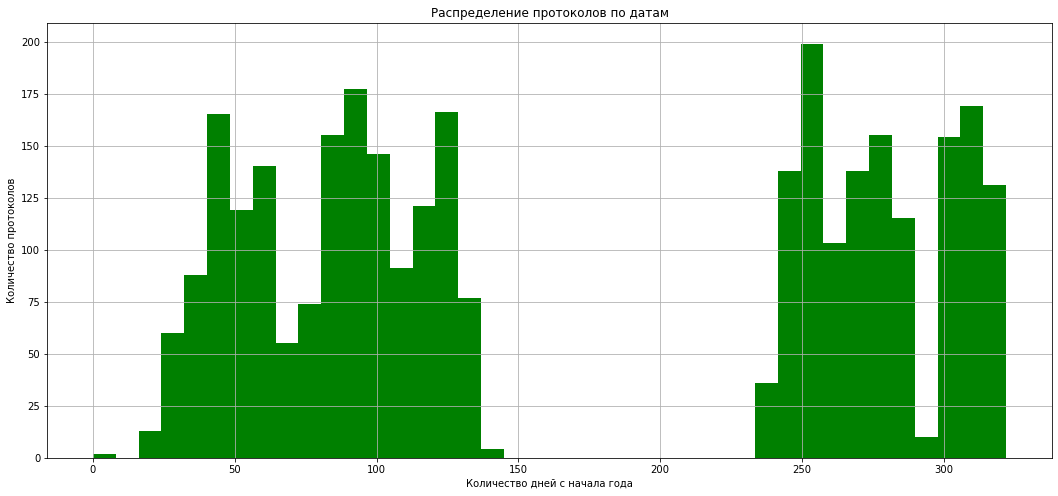

In [8]:
#df_time[df_time['days']<200].hist(bins=40, color='r')
#df_time[df_time['days']>200].hist(bins=40, color='g')
df_time['days'].hist(bins=40, color='g')

plt.title("Распределение протоколов по датам")
plt.xlabel('Количество дней с начала года')
plt.ylabel('Количество протоколов')

In [9]:
# Посчитаем минимальную дату для осеннего периода
fall_min = df_time[df_time['days']>200]['days'].min()
fall_min

234

In [10]:
# Добавим колонки "Количество дней с начала текущего периода" и "Период"

df_time['period'] = df_time.apply(lambda x: 1 if x['days']<fall_min else 2, axis=1) 
df_time['day_of_period'] = df_time.apply(lambda x: x['days'] if x['days']<fall_min else x['days']-fall_min, axis=1) 

df_time[['period','days','day_of_period']].head(-10)

,period,days,day_of_period
0,1,18,18
1,1,19,19
2,1,19,19
3,1,21,21
4,1,24,24
...,...,...,...
2986,2,315,81
2987,2,318,84
2988,2,318,84
2989,2,318,84


In [11]:
# Для формирования колонки interval, в которой для каждого протокола нужно фиксировать, 
# сколько дней прошло до текущего урока текущего учителя со дня предыдущего урока,
# создадим словарь словарей, в котором ключами первого словаря будут id учителей, 
# ключами вложенных словарей - id протоколов, а значениями - интервалы для текущего протокола)

teachers_prots = {}
teachers = df_time['teacher_id'].unique().tolist()
for teacher in teachers:
    t_df_spring = df_time[((df_time['teacher_id']==teacher) & (df_time['period']==1))][['prot_id', 'day_of_period']].sort_values(by='day_of_period')
    t_df_spring['interval'] = t_df_spring['day_of_period'] - t_df_spring['day_of_period'].shift(1)
    t_df_fall = df_time[((df_time['teacher_id']==teacher) & (df_time['period']==2))][['prot_id', 'day_of_period']].sort_values(by='day_of_period')
    t_df_fall['interval'] = t_df_fall['day_of_period'] - t_df_fall['day_of_period'].shift(1)
   
    teachers_prots[teacher] = {row['prot_id']: row['interval'] for row in t_df_spring.append(t_df_fall).to_dict('records')}
#print(teachers_prots[726][815])
#print(teachers_prots)

In [12]:
# Добавим эту колонку
df_time['interval'] = df_time.apply(lambda x: teachers_prots[x['teacher_id']][x['prot_id']], axis=1) 
df_time.head(2)

,prot_id,template_code,date_of_lesson,org_id,teacher_id,observer_id,curator_id,class,satisfaction,wish_to_change,...,attention_strong,attention_middle,attention_weak,teacher_comments,group,level,days,period,day_of_period,interval
0,816,П1.1,01.02.2022,133,726,725,724,NaN,NaN,NaN,...,NaN,NaN,NaN,Больше внимания уделять слабым ученикам и моти...,Распределение внимания учителя,1,18,1,18,NaN
1,1162,П1.1,02.02.2022,128,736,735,734,NaN,NaN,NaN,...,NaN,NaN,NaN,Учитель уделяет внимание всем учащимся,Распределение внимания учителя,1,19,1,19,NaN


#### Посмотрим сразу же статистические распределения по этому параметру для весны и осени
- Вначале - Боксплоты
- Потом - отдельно гистограммы по весне и по осени

<AxesSubplot:title={'center':'Дни заполнения протоколов по периодам (1 - весна, 2 - осень)'}, xlabel='period', ylabel='interval'>

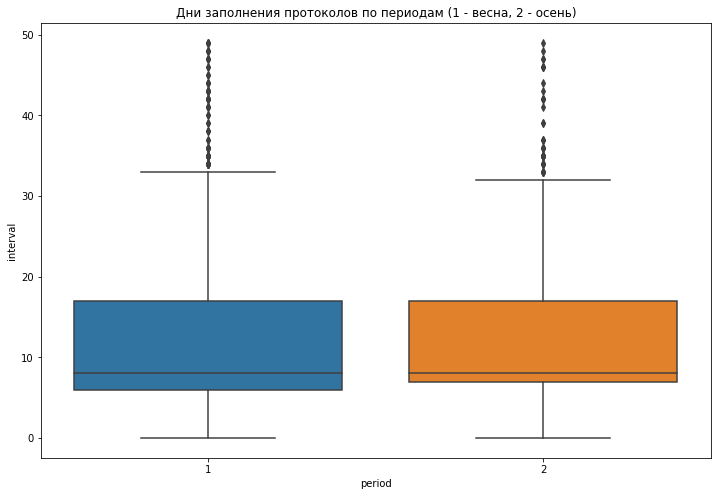

In [13]:
plt.rcParams['figure.figsize'] = (12.0, 8.0)
plt.title('Дни заполнения протоколов по периодам (1 - весна, 2 - осень)')

sns.boxplot(y=df_time[df_time['interval']<50]['interval'], x=df_time['period']) 

Text(0.5, 1.0, 'Интервалы между уроками весной')

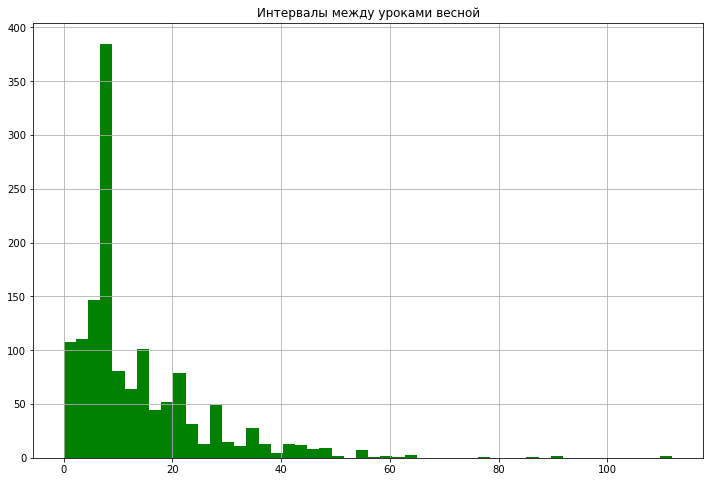

In [14]:
df_time[df_time['period']==1]['interval'].hist(bins=50, color='green')
plt.title('Интервалы между уроками весной')

Text(0.5, 1.0, 'Интервалы между уроками осенью')

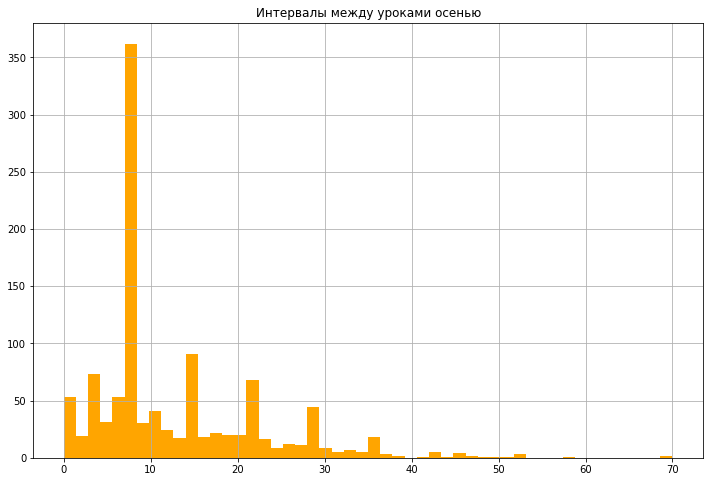

In [15]:
df_time[df_time['period']==2]['interval'].hist(bins=50, color='orange')
plt.title('Интервалы между уроками осенью')

### Краткое резюме по вторичным колонкам, связанным со временем (по всем протоколам)
- распределения по времени проведения уроков неравномерны по месяцам. Это может быть связано с особенностями организации учебной программы и периодами сдачи промежуточных отчетов. Кроме того, на возможность проведения уроков с присутствием на уроке коллеги, играющего роль наблюдателя, могут быть ограничены в случае, если у школы возникают какие-либо повышенные нагрузки, из-за которых учителя не имеют времени для посещений уроков. Такие периоды могут совпадать в разных школах одного и того же региона, если нагрузка "провоцируется", к примеру, вышестоящим начальством. Конечно, возможны "провалы" в графиках из-за школьных каникул. Если учеников нет в школе, то и уроки не проводятся.
- Интервалы между уроками очень разные, и этот параметр будет более интересным посмотреть на уровне отдельных учителей (средние показатели и дисперсии). Однако бросаются в глаза периодические пики, кратные 7 дням. Очевидно, что многие учителя в рамках проекта установили для себя определенные дни недели для проведения протоколирования своих уроков и пытались следовать этому расписанию. Видимо, это практиковалось некоторыми учителями в том числе для того, чтобы проводить уроки только в одном из своих классов, чтобы появилась возможность фиксировать динамику изменений в этом классе.


### Добавляем колонки по группам учеников
1. Добавим колонку **scope** (отношение количества учеников, с которыми взаимодействовал учитель, к общему количеству учеников на уроке. nan если поля pupils_all или attention_all нулевые или равны nan, и attention_all/pupils_all в противном случае)
2. Добавим колонку **pupils_m** (матожидание среднего уровня учеников на уроке. Число от 0 до 1)
3. Добавим колонку **pupils_d** (дисперсия уровня учеников на уроке. Число от 0 до 1)
4. Добавим колонку **interactions_m**
5. Добавим колонку **interactions_d**
6. Добавим колонку **attention_m**
7. Добавим колонку **attention_d**
8. Добавим колонку **vector_interact** (Вектор взаимодействия - разница между pupils_m и interactions_m)
9. Добавим колонку **vector_intention** (Вектор намерения - разница между pupils_m и attention_m)
10. Добавим колонку **vector_attention** (Вектор внимания - разница между attention_m и interactions_m)

In [16]:
# Создадим копию текущего датасета, чтобы можно было при отладке кода начинать не с начала, а с этой ячейки
df_levels = df_time.copy()

In [17]:
#Проверяем, есть ли протоколы с некорректными данными 
# (количество учеников, с которыми взаимодействовал учитель, больше, чем количество учеников на уроке)
# Наличие таких записей будет говорить о невалидности данных таких протоколов. 
df_levels[(df_levels['attention_all']>df_levels['pupils_all'])][['prot_id', 'pupils_all', 'attention_all']]

,prot_id,pupils_all,attention_all
132,314,16.0,21.0
188,296,11.0,20.0
191,210,9.0,23.0
195,205,9.0,23.0
551,1657,9.0,10.0
789,2958,7.0,102.0
796,2997,26.0,48.0
799,598,11.0,37.0
872,1690,2.0,6.0
1010,2820,7.0,11.0


In [18]:
df_levels['attention_all'].describe()

count    2643.000000
mean        9.494892
std         6.573830
min         1.000000
25%         5.000000
50%         8.000000
75%        12.000000
max       102.000000
Name: attention_all, dtype: float64

In [19]:
# Добавляем колонку scope
df_levels['scope'] = df_levels.apply(lambda x: x['attention_all']/x['pupils_all'] 
                                     if ((x['attention_all'] <= x['pupils_all']) & (x['pupils_all']>0) & (x['attention_all']>0))  
                                     else np.nan, axis=1)
df_levels['scope'].describe()

count    2600.000000
mean        0.907798
std         0.161486
min         0.187500
25%         0.857143
50%         1.000000
75%         1.000000
max         1.000000
Name: scope, dtype: float64

Text(0.5, 1.0, 'Доля учеников на уроке, с которыми взаимодействует учитель')

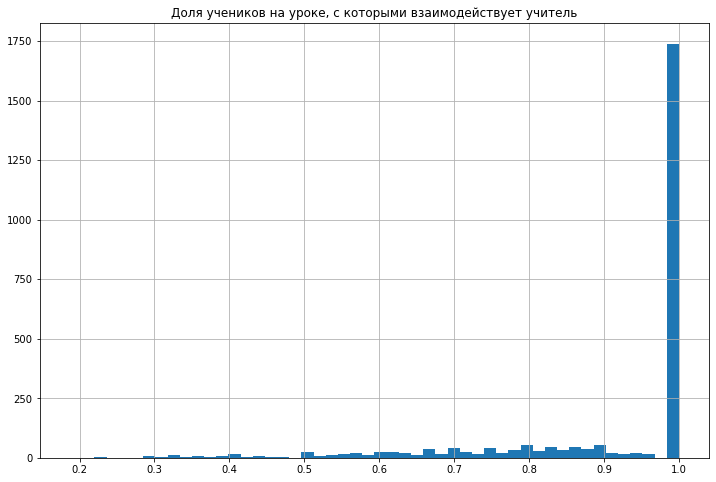

In [20]:
df_levels['scope'].hist(bins=50)
plt.title('Доля учеников на уроке, с которыми взаимодействует учитель')

In [21]:
def calc_M_D(df_cols):
    M, D = np.nan, np.nan
    Y1, Y2, Y3 = df_cols
    Y = Y1 + Y2 + Y3
    if (Y>0):
        M = (Y1 + Y2*0.5)/Y
        D = ((Y1*(M-1)**2 + Y2*(M-0.5)**2 + Y3*M**2)/Y)**0.5
    return pd.Series([M, D])    

In [22]:
# Создаем промежуточный датафрейм для экспериментов
df_md = df_levels.iloc[:,:].copy()

In [23]:
%%time
# Добавляем колонки с матожиданием и дисперсией для количества учеников разных уровней на уроке
df_md[['pupils_m', 'pupils_d']] = df_md[['pupils_strong', 'pupils_middle', 'pupils_weak']].apply(calc_M_D, axis=1)

Wall time: 2.84 s


In [24]:
# Выведем несколько строчек из середины и посмотрим на цифры
df_md.iloc[-150:-130, :][['pupils_strong', 'pupils_middle', 'pupils_weak', 'pupils_m', 'pupils_d']].head(20)

,pupils_strong,pupils_middle,pupils_weak,pupils_m,pupils_d
2851,7.0,6.0,7.0,0.500000,0.418330
2852,2.0,4.0,2.0,0.500000,0.353553
2853,0.0,4.0,4.0,0.250000,0.250000
2854,3.0,2.0,3.0,0.500000,0.433013
2855,5.0,4.0,8.0,0.411765,0.428242
2856,0.0,1.0,1.0,0.250000,0.250000
2857,1.0,1.0,1.0,0.500000,0.408248
2858,4.0,9.0,2.0,0.566667,0.309121
2859,3.0,10.0,4.0,0.470588,0.319494
2860,8.0,10.0,5.0,0.565217,0.370204


Text(0, 0.5, 'Количество уроков')

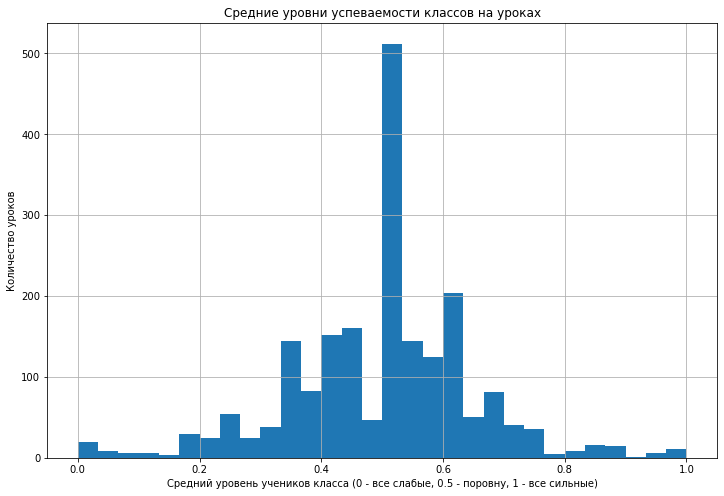

In [25]:
df_md['pupils_m'].hist(bins=30)
plt.title('Средние уровни успеваемости классов на уроках')
plt.xlabel('Средний уровень учеников класса (0 - все слабые, 0.5 - поровну, 1 - все сильные)')
plt.ylabel('Количество уроков')

Text(0, 0.5, 'Количество уроков')

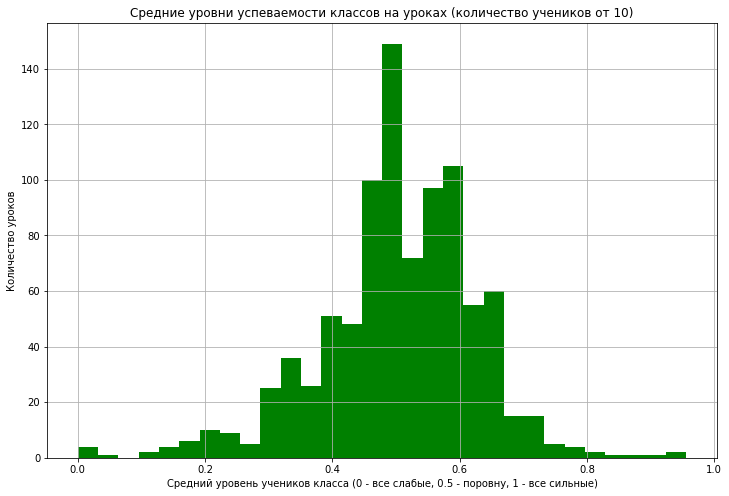

In [26]:
df_md[df_md['pupils_all']>9]['pupils_m'].hist(bins=30, color='g')
plt.title('Средние уровни успеваемости классов на уроках (количество учеников от 10)')
plt.xlabel('Средний уровень учеников класса (0 - все слабые, 0.5 - поровну, 1 - все сильные)')
plt.ylabel('Количество уроков')

Text(0, 0.5, 'Количество уроков')

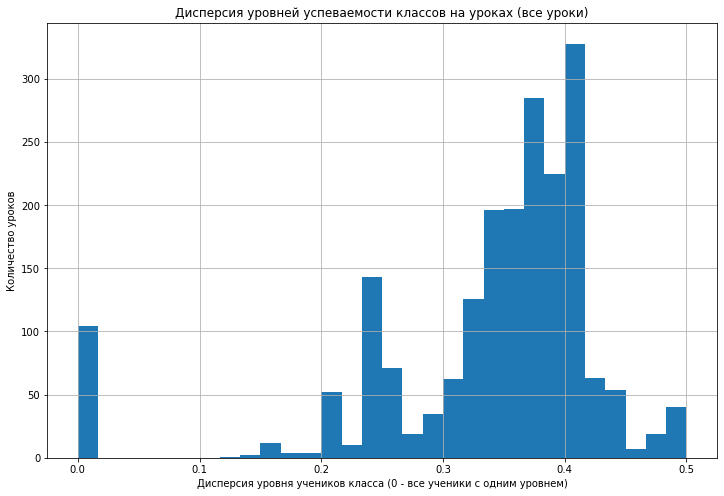

In [27]:
df_md['pupils_d'].hist(bins=30)
plt.title('Дисперсия уровней успеваемости классов на уроках (все уроки)')
plt.xlabel('Дисперсия уровня учеников класса (0 - все ученики с одним уровнем)')
plt.ylabel('Количество уроков')

Text(0, 0.5, 'Количество уроков')

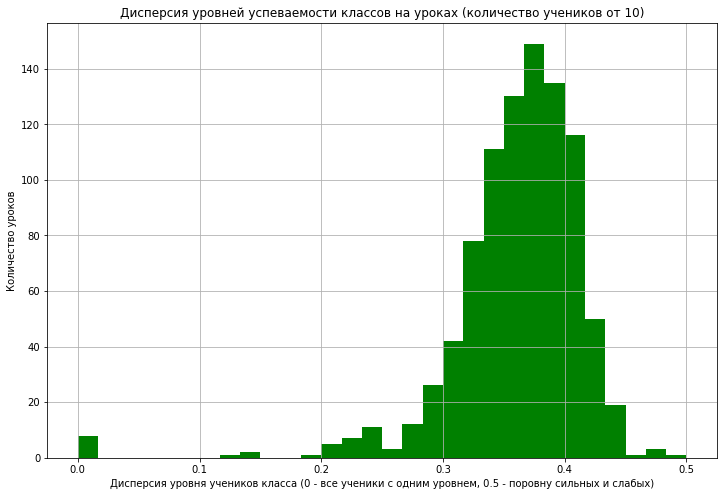

In [28]:
df_md[df_md['pupils_all']>9]['pupils_d'].hist(bins=30, color='g')
plt.title('Дисперсия уровней успеваемости классов на уроках (количество учеников от 10)')
plt.xlabel('Дисперсия уровня учеников класса (0 - все ученики с одним уровнем, 0.5 - поровну сильных и слабых)')
plt.ylabel('Количество уроков')

In [29]:
%%time
# Добавляем колонки с матожиданием и дисперсией для количества учеников разных уровней на уроке, с которыми взаимодействовал учитель
df_md[['attention_m', 'attention_d']] = df_md[['attention_strong', 'attention_middle', 'attention_weak']].apply(calc_M_D, axis=1)

Wall time: 2.94 s


Text(0, 0.5, 'Количество уроков')

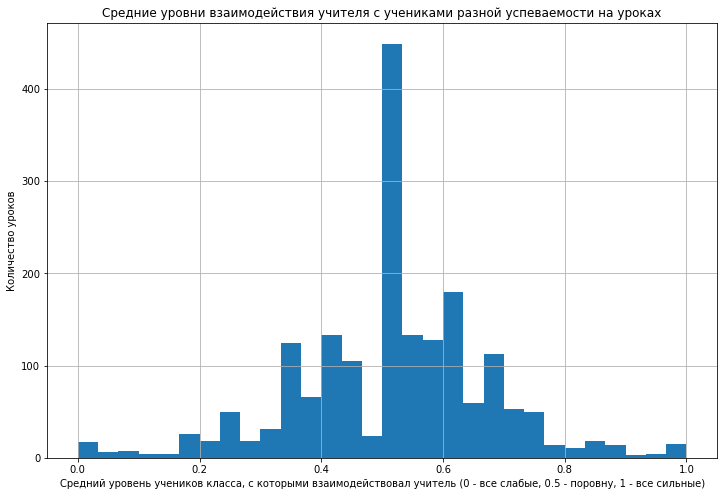

In [30]:
df_md['attention_m'].hist(bins=30)
plt.title('Средние уровни взаимодействия учителя с учениками разной успеваемости на уроках')
plt.xlabel('Средний уровень учеников класса, с которыми взаимодействовал учитель (0 - все слабые, 0.5 - поровну, 1 - все сильные)')
plt.ylabel('Количество уроков')

In [31]:
%%time
# Добавляем колонки с матожиданием и дисперсией для количества взаимодействий учителя с учениками разных уровней
df_md[['interactions_m', 'interactions_d']] = df_md[['interactions_strong', 'interactions_middle', 'interactions_weak']].apply(calc_M_D, axis=1)

Wall time: 4.16 s


Text(0, 0.5, 'Количество уроков')

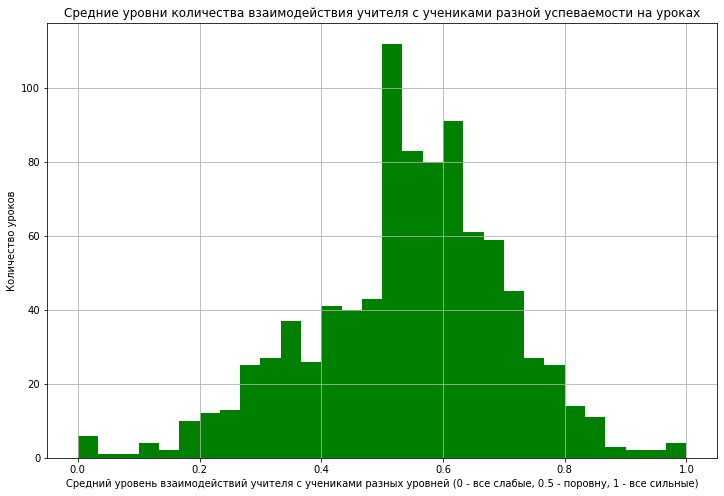

In [32]:
df_md['interactions_m'].hist(bins=30, color='g')
plt.title('Средние уровни количества взаимодействия учителя с учениками разной успеваемости на уроках')
plt.xlabel('Средний уровень взаимодействий учителя с учениками разных уровней (0 - все слабые, 0.5 - поровну, 1 - все сильные)')
plt.ylabel('Количество уроков')

In [33]:
# Добавляем колонки - "вектора"
df_md['vector_interact'] = df_md['pupils_m'] - df_md['interactions_m']
df_md['vector_intention'] = df_md['pupils_m'] - df_md['attention_m']
df_md['vector_attention'] = df_md['attention_m'] - df_md['interactions_m']

In [34]:
df_md.describe()

,prot_id,org_id,teacher_id,observer_id,curator_id,class,satisfaction,wish_to_change,pupils_all,pupils_strong,...,scope,pupils_m,pupils_d,attention_m,attention_d,interactions_m,interactions_d,vector_interact,vector_intention,vector_attention
count,3001.000000,3001.000000,3001.000000,3001.000000,3001.000000,872.000000,1016.000000,952.000000,3001.000000,2059.000000,...,2600.000000,2059.000000,2059.000000,1876.000000,1876.000000,907.000000,907.000000,907.000000,1876.000000,735.000000
mean,1579.222926,102.580806,713.616794,713.660447,706.233256,5.472477,3.485236,2.161765,10.825392,3.139388,...,0.907798,0.493401,0.337319,0.510816,0.331213,0.539929,0.335055,-0.044510,-0.016755,-0.025294
std,890.060019,23.647302,137.508598,137.603640,134.675950,2.524129,0.633839,0.972324,7.017989,2.791159,...,0.161486,0.151565,0.101413,0.158947,0.104443,0.160938,0.094332,0.098771,0.064274,0.085356
min,41.000000,1.000000,472.000000,472.000000,471.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.187500,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.550000,-0.500000,-0.550000
25%,805.000000,88.000000,597.000000,597.000000,595.000000,3.000000,3.000000,1.000000,6.000000,1.000000,...,0.857143,0.416667,0.316228,0.428571,0.299739,0.451190,0.299053,-0.093813,0.000000,-0.064870
50%,1575.000000,108.000000,719.000000,719.000000,709.000000,6.000000,4.000000,2.000000,9.000000,2.000000,...,1.000000,0.500000,0.364931,0.500000,0.355270,0.555556,0.358924,-0.030303,0.000000,-0.014286
75%,2356.000000,121.000000,827.000000,827.000000,819.000000,7.000000,4.000000,3.000000,15.000000,4.000000,...,1.000000,0.586957,0.400000,0.607531,0.395285,0.647059,0.393320,0.000000,0.000000,0.014453
max,3115.000000,133.000000,970.000000,970.000000,952.000000,11.000000,4.000000,4.000000,34.000000,21.000000,...,1.000000,1.000000,0.500000,1.000000,0.500000,1.000000,0.500000,0.493421,0.500000,0.312500


In [35]:
df_md.iloc[-150:-140,:]

,prot_id,template_code,date_of_lesson,org_id,teacher_id,observer_id,curator_id,class,satisfaction,wish_to_change,...,scope,pupils_m,pupils_d,attention_m,attention_d,interactions_m,interactions_d,vector_interact,vector_intention,vector_attention
2851,448,П6.3,26.05.2022,111,802,801,792,NaN,NaN,NaN,...,0.700000,0.500000,0.418330,0.642857,0.349927,NaN,NaN,NaN,-0.142857,NaN
2852,443,П6.3,30.05.2022,92,586,585,584,NaN,NaN,NaN,...,1.000000,0.500000,0.353553,0.500000,0.353553,NaN,NaN,NaN,0.000000,NaN
2853,1862,П6.3,15.09.2022,121,905,942,909,NaN,NaN,NaN,...,0.500000,0.250000,0.250000,0.375000,0.216506,NaN,NaN,NaN,-0.125000,NaN
2854,1855,П6.3,27.09.2022,121,907,908,911,NaN,NaN,NaN,...,0.625000,0.500000,0.433013,0.600000,0.374166,NaN,NaN,NaN,-0.100000,NaN
2855,1852,П6.3,29.09.2022,121,903,941,910,NaN,NaN,NaN,...,0.823529,0.411765,0.428242,0.500000,0.422577,NaN,NaN,NaN,-0.088235,NaN
2856,2581,П6.3,04.10.2022,102,656,657,658,9.0,3.0,3.0,...,1.000000,0.250000,0.250000,0.250000,0.250000,0.281250,0.248039,-0.031250,0.000000,-0.031250
2857,2753,П6.3,15.10.2022,95,606,607,605,7.0,3.0,2.0,...,1.000000,0.500000,0.408248,0.500000,0.408248,0.500000,0.422577,0.000000,0.000000,0.000000
2858,2574,П6.3,17.10.2022,101,654,954,650,6.0,4.0,1.0,...,0.866667,0.566667,0.309121,0.538462,0.307692,0.560606,0.342840,0.006061,0.028205,-0.022145
2859,2570,П6.3,19.10.2022,101,954,654,650,7.0,4.0,3.0,...,0.764706,0.470588,0.319494,0.500000,0.277350,0.615385,0.252209,-0.144796,-0.029412,-0.115385
2860,2193,П6.3,20.10.2022,119,853,852,851,NaN,2.0,3.0,...,0.739130,0.565217,0.370204,0.705882,0.299942,0.812500,0.242061,-0.247283,-0.140665,-0.106618


Text(0, 0.5, 'Количество уроков')

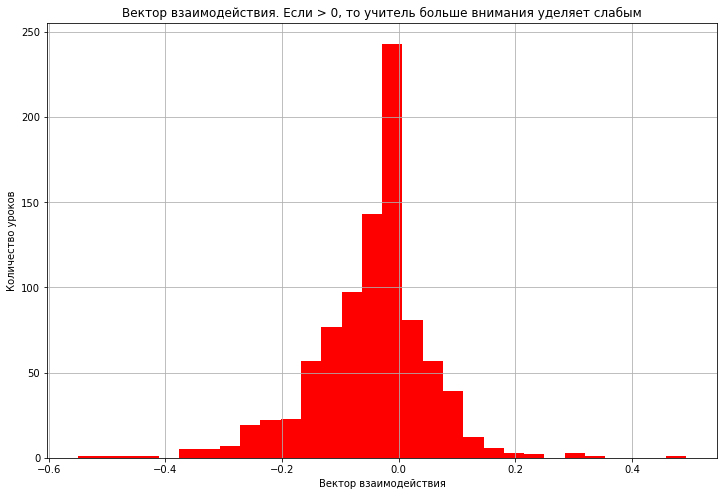

In [36]:
df_md['vector_interact'].hist(bins=30, color='r')
plt.title('Вектор взаимодействия. Если > 0, то учитель больше внимания уделяет слабым')
plt.xlabel('Вектор взаимодействия')
plt.ylabel('Количество уроков')

Text(0, 0.5, 'Количество уроков')

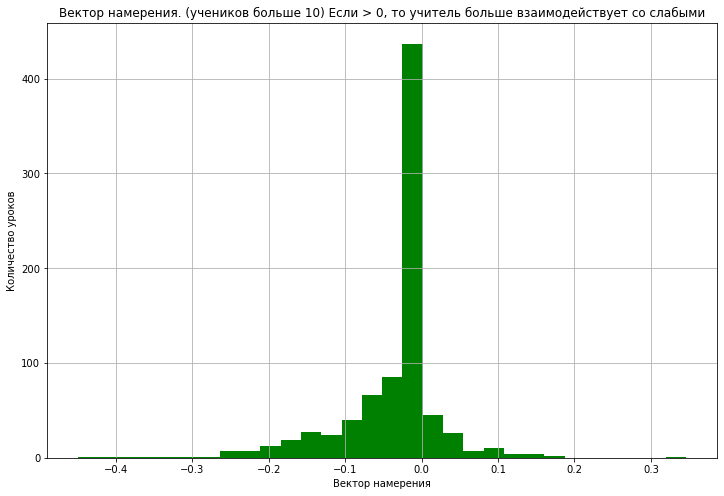

In [37]:
df_md[df_md['pupils_all']>9]['vector_intention'].hist(bins=30, color='g')
plt.title('Вектор намерения. (учеников больше 10) Если > 0, то учитель больше взаимодействует со слабыми')
plt.xlabel('Вектор намерения')
plt.ylabel('Количество уроков')

<AxesSubplot:>

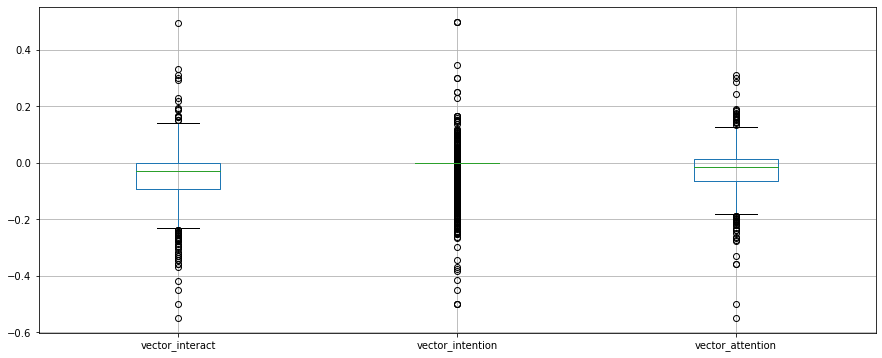

In [38]:
# Сравним три вектора:
plt.rcParams['figure.figsize'] = (15.0, 6)
df_md[['vector_interact', 'vector_intention', 'vector_attention']].boxplot()

In [39]:
df_md.columns

Index(['prot_id', 'template_code', 'date_of_lesson', 'org_id', 'teacher_id',
       'observer_id', 'curator_id', 'class', 'satisfaction', 'wish_to_change',
       'pupils_all', 'pupils_strong', 'pupils_middle', 'pupils_weak',
       'interactions_all', 'interactions_strong', 'interactions_middle',
       'interactions_weak', 'attention_all', 'attention_strong',
       'attention_middle', 'attention_weak', 'teacher_comments', 'group',
       'level', 'days', 'period', 'day_of_period', 'interval', 'scope',
       'pupils_m', 'pupils_d', 'attention_m', 'attention_d', 'interactions_m',
       'interactions_d', 'vector_interact', 'vector_intention',
       'vector_attention'],
      dtype='object')

Text(0.5, 1.0, 'Матрица корреляции параметров основного датафрейма')

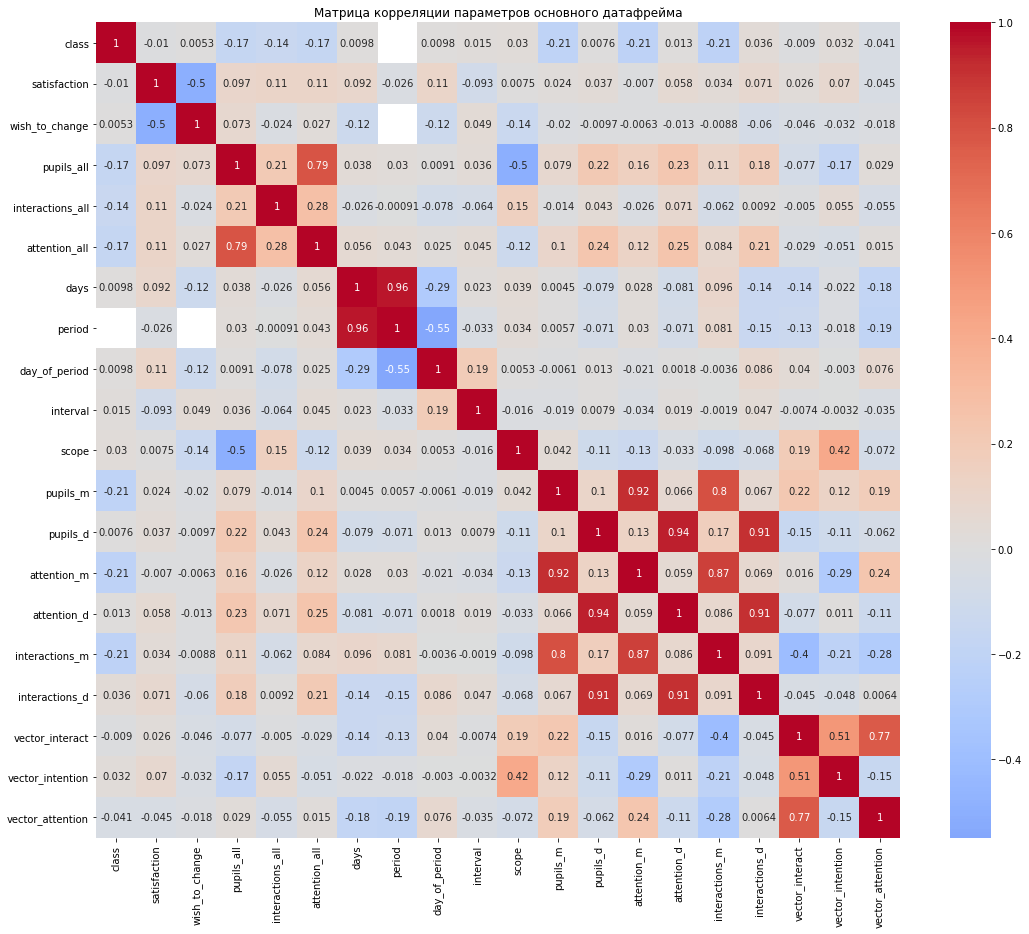

In [40]:
plt.rcParams['figure.figsize'] = (18, 15)
cols_for_corr = ['class', 'satisfaction', 'wish_to_change',
       'pupils_all', 'interactions_all', 'attention_all', 'days',
       'period', 'day_of_period', 'interval', 'scope', 'pupils_m', 'pupils_d',
       'attention_m', 'attention_d', 'interactions_m', 'interactions_d',
       'vector_interact', 'vector_intention', 'vector_attention']
sns.heatmap(df_md[cols_for_corr].corr(), annot = True, center= 0, cmap= 'coolwarm')
plt.title('Матрица корреляции параметров основного датафрейма')

#### Краткий анализ матрицы корреляции
Особых неожиданностей эта матрица не принесла, но кое-что интересное тут все-таки видно.
- отрицательная корреляция поля class со средней оценкой успеваемости класса говорит о том, что в рамках этого проекта более успешными оказываются ученики младших классов, чем старшеклассники. Это - неожиданно, но интерптераций может быть много, в том числе связанных с психологией учителей.
- заметная отрицательная корреляция колонок satisfaction, wish_to_change понятны. Чем более не удовлетворен учитель проведенным уроком, тем больше шансов, что у него может появиться желание что-то поменять. И наоборот. К сожалению, других существенных корреляций с полем удовлетворенности уроком в этих данных не видно.
- Интересны корреляции с полем Scope (доля учеников класса, с которыми взаимодействовал учитель). Отрицательная корреляция с полем Pupils_all почти наверняка вызвана тем, что значительная часть классов в проекте малокомплектна, и фактически в малых классах учитель во время урока успевает пообщаться со всеми учениками. Эту же матрицу ниже посмотрим только для крупных классов. Также относительно неожиданна положительная корреляция этого поля с полем vector_intention. Оба эти поля являются вторичными, но вычисляются на основании разных параметров. Запомним это интересное наблюдение.
- Высокие взаимные корреляции между колонками в правом нижнем углу матрицы понятны, 

Text(0.5, 1.0, 'Матрица корреляции параметров основного датафрейма (для классов, в которых 13 и более учеников)')

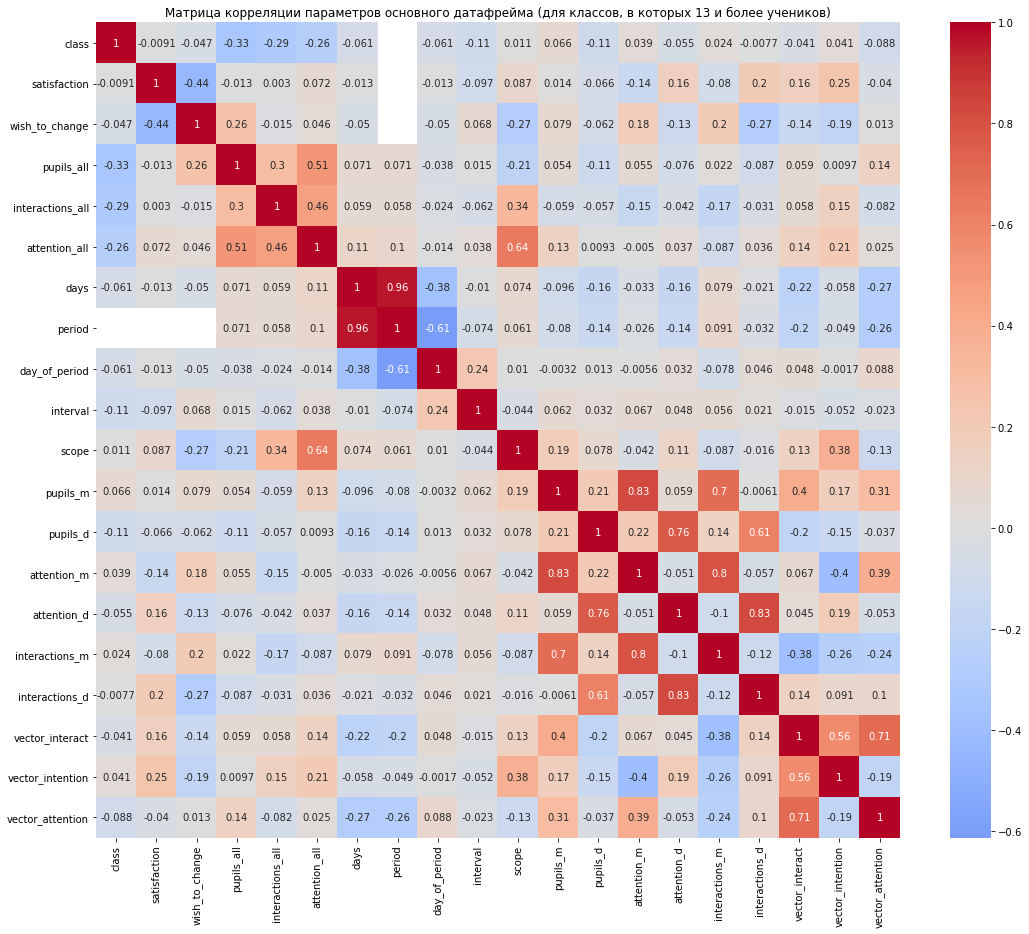

In [41]:
# Сразу же посмотрим на такую же матрицу, но для классов, количество учеников в которых - от 13 и выше.

sns.heatmap(df_md[df_md['pupils_all']>12][cols_for_corr].corr(), annot = True, center= 0, cmap= 'coolwarm')
plt.title('Матрица корреляции параметров основного датафрейма (для классов, в которых 13 и более учеников)')

In [42]:
# Сохраним новый дополненный датафрейм в файле, который сможем дальше использовать для вычислений.
df_md.to_csv('data/intermid/full_df_extended.csv', sep=';')

### Посмотрим на протоколы отдельного учителя в динамике

Для этого вначале отберем несколько тестовых Id учителей с заметным числом протоколов, а потом посмотрим на данные этих протоколов.

In [43]:
# Ищем самых продуктивных учителей
df_md['teacher_id'].value_counts().iloc[:20]

826    25
736    24
566    22
565    22
929    20
802    20
928    20
829    20
671    19
670    19
898    19
632    19
827    19
606    19
607    19
601    19
539    19
733    18
820    18
641    18
Name: teacher_id, dtype: int64

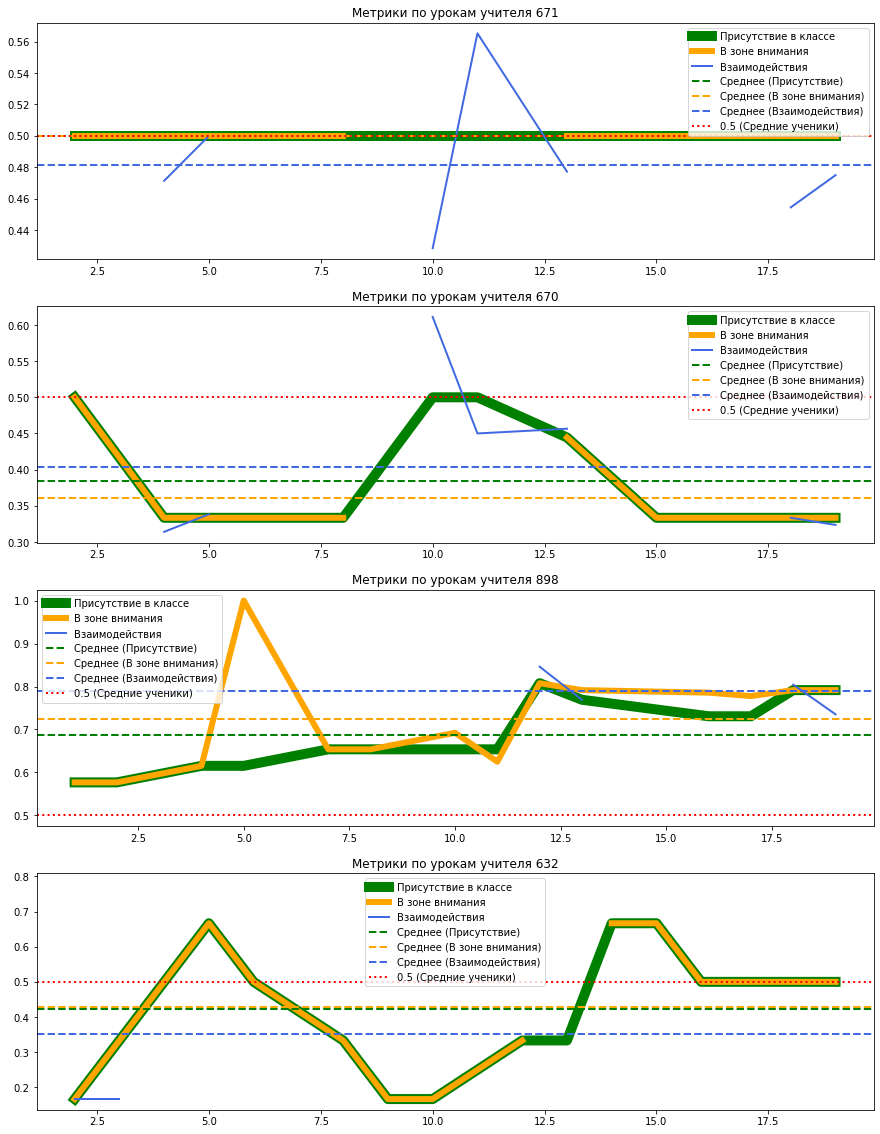

In [44]:
def plot_teacher_metrics(id):
    df_ = df_md[df_md['teacher_id'] == id].sort_values(by='days').copy().reset_index()
    df_.index = df_.index + 1
    df_[df_['pupils_m']>0]['pupils_m'].plot(linewidth=10, color='g', label='Присутствие в классе')
    df_[df_['pupils_m']>0]['attention_m'].plot(linewidth=6, color='orange', label='В зоне внимания')
    df_[df_['pupils_m']>0]['interactions_m'].plot(linewidth=2, label='Взаимодействия', color='royalblue')
    plt.axhline(df_['pupils_m'].mean(), linestyle='dashed', linewidth=2, color='g', label='Среднее (Присутствие)')
    plt.axhline(df_['attention_m'].mean(), linestyle='dashed', linewidth=2, color='orange', label='Среднее (В зоне внимания)')
    plt.axhline(df_['interactions_m'].mean(), linestyle='dashed', linewidth=2, color='royalblue', label='Среднее (Взаимодействия)')
    plt.axhline(0.5, color='r', linestyle='dotted', linewidth=2, label='0.5 (Средние ученики)')
    plt.title('Метрики по урокам учителя ' + str(id))
    plt.legend()
    

def plot_teachers_metrics(ids):
    cnt = len(ids)
    plt.rcParams['figure.figsize'] = (15.0, cnt*5)
    for ind_, id in enumerate(ids):
        plt.subplot(cnt,1,ind_+1)
        plot_teacher_metrics(id)       

teachers_with_19_lessons = [671, 670, 898, 632, 827, 606, 607, 601, 539]         
plot_teachers_metrics(teachers_with_19_lessons[:4])

In [45]:
# А теперь возьмем середнячков
mean_teachers = df_md['teacher_id'].value_counts().iloc[100:105].index.tolist()
df_md['teacher_id'].value_counts().iloc[100:105]

771    12
624    12
555    12
629    12
637    12
Name: teacher_id, dtype: int64

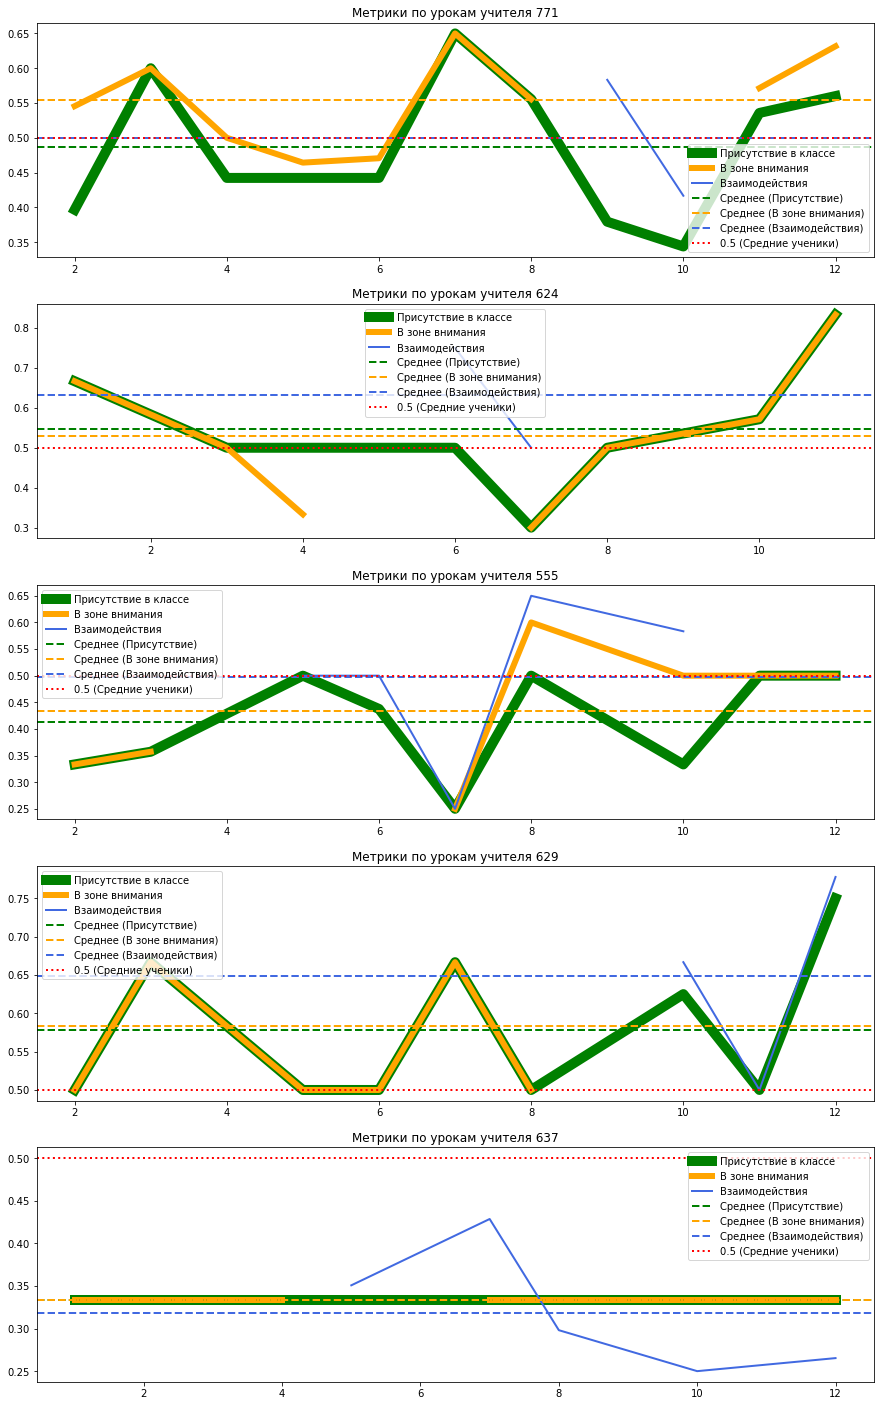

In [46]:
plot_teachers_metrics(mean_teachers)

#### Посмотрим на эти же данные по учителям под другим углом
Будем сравнивать вектора внимания и намерения учителя для весеннего и осеннего периода.
Есть ощущение, что в силу малого объема данных по проекту, возможной фиксации данных по урокам одного учителя в разных классах, имеющих другие метрики, анализ выше рассмотренных графиков слишком затруднен.
При этом усредненные вектора внимания по весне и по осени теоретически могут показать, изменился ли каким-то образом паттерн работы учителя за год с точки зрения того, какую группу учеников по успеваемости учитель попытался поддерживать больше.


In [47]:

def plot_teacher_vectors(id):
    df_ = df_md[df_md['teacher_id'] == id].sort_values(by='days').copy().reset_index()
    df_.index = df_.index + 1

    v_interact_spring = df_[df_['period'] == 1]['vector_interact'].mean()
    v_interact_fall = df_[df_['period'] == 2]['vector_interact'].mean()
    df_['vector_interact'] = df_.apply(lambda x: v_interact_spring if x['period']==1 else v_interact_fall , axis=1)

    v_intention_spring = df_[df_['period'] == 1]['vector_intention'].mean()
    v_intention_fall = df_[df_['period'] == 2]['vector_intention'].mean()
    df_['vector_intention'] = df_.apply(lambda x: v_intention_spring if x['period']==1 else v_intention_fall , axis=1)

    df_['vector_interact'].plot(linewidth=5, color='g', label='Вектор охвата')
    df_['vector_intention'].plot(linewidth=3, color='orange', label='Вектор намерения')

    plt.axhline(0, color='r', linestyle='dotted', linewidth=2, label='0 (Нулевой вектор)')
    plt.title('Вектора учителя ' + str(id))
    plt.legend()
    

def plot_teachers_vectors(ids):
    cnt = len(ids)
    plt.rcParams['figure.figsize'] = (15.0, cnt*5)
    for ind_, id in enumerate(ids):
        plt.subplot(cnt,1,ind_+1)
        plot_teacher_vectors(id)       


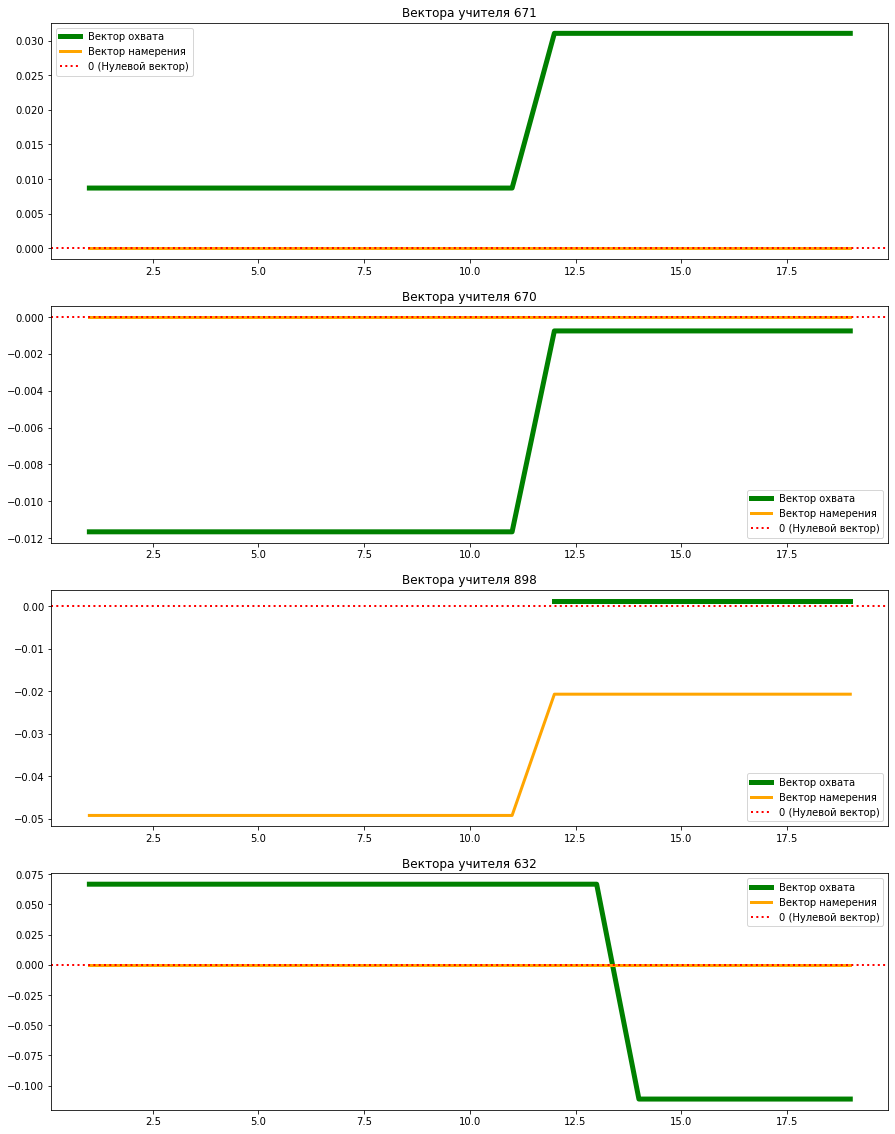

In [48]:
plot_teachers_vectors(teachers_with_19_lessons[:4])

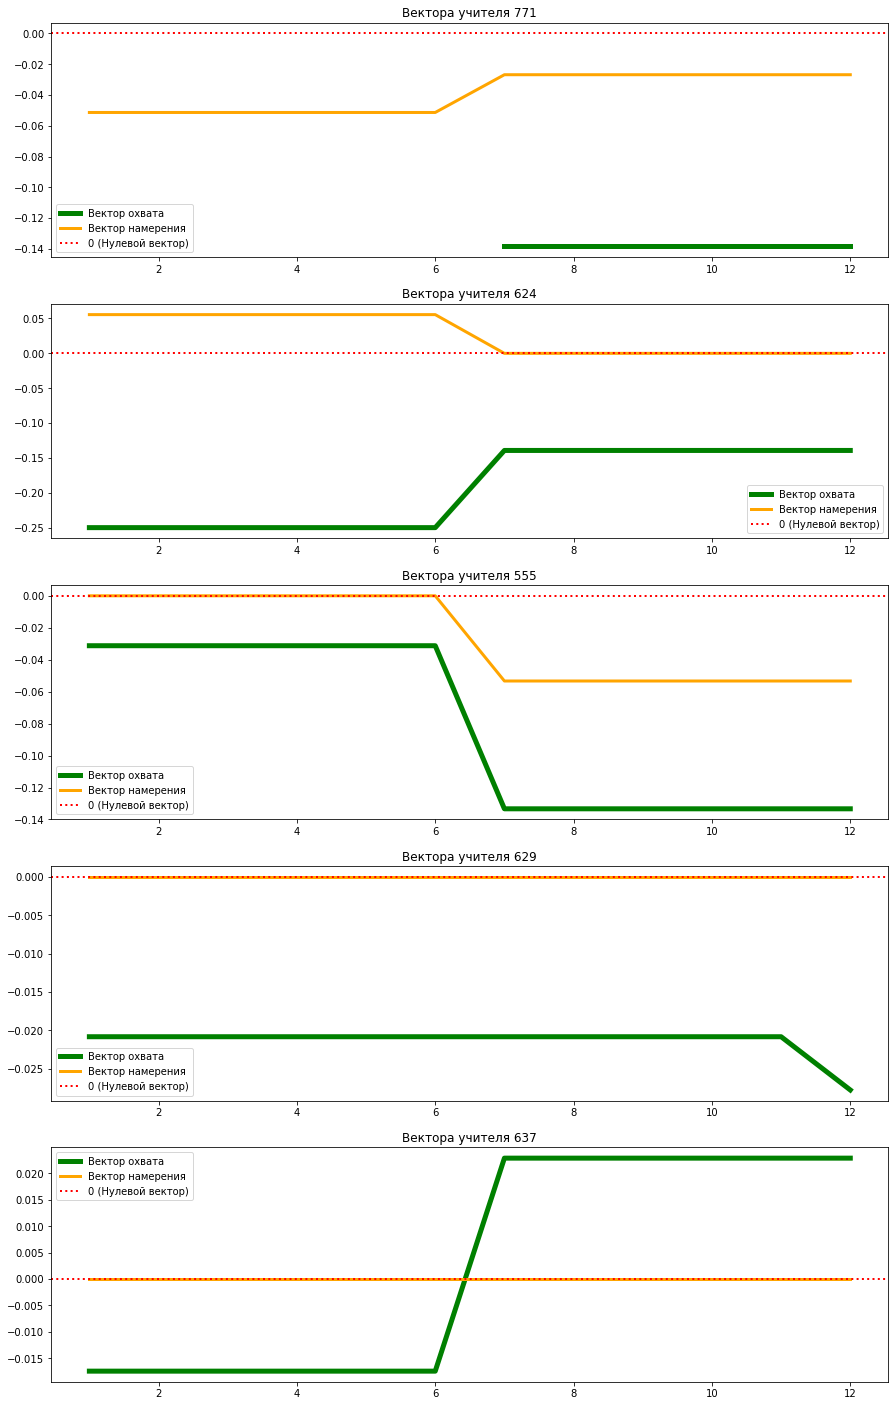

In [49]:
# Смотрим то же самое для учителей - "середнячков" (в течение года заполнили по 10 протоколов)

plot_teachers_vectors(mean_teachers)

Ещё один вариант анализа динамики наблюдений на уроках - это анализ изменения двух параметров, появившихся в протоколах только осенью - самооценка учителями степени своей удовлетворенности проведенным уроком и наличие намерений каким-то образом изменить паттерн своего поведения на следующих уроках.

Подготовим еще одну функцию, которая позволит посмотреть на эти параметры для тех же учителей.
Оба параметра изменяются от 1 до 4.
1 соответствует ответу Нет, 2 - ответу Скорее нет, 3 - ответу Скорее да, 4 - ответу Да


In [50]:
def plot_teacher_selfanalysis(id):
    df_ = df_md[df_md['teacher_id'] == id].sort_values(by='days').copy().reset_index()
    df_.index = df_.index + 1

    df_['satisfaction'].fillna(0).plot(linewidth=5, color='g', label='Удовлетворенность уроком')
    df_['wish_to_change'].fillna(0).plot(linewidth=3, color='orange', label='Желание что-то изменить')
    plt.axhline(1, color='r', linestyle='dotted', linewidth=2, label='НЕТ')
    plt.axhline(4, color='b', linestyle='dotted', linewidth=2, label='ДА')
    plt.title('Рефлексия учителя ' + str(id))
    plt.legend()
    plt.show
    print(f'\nКомментарии учителя {id} к уроку:')
    for ind, lesson in df_['teacher_comments'].items():
        print(ind, lesson)    

def plot_teachers_selfanalysis(ids):
    cnt = len(ids)
    plt.rcParams['figure.figsize'] = (15.0, cnt*10)
    for ind_, id in enumerate(ids):
        plt.subplot(cnt,1,ind_+1)
        plot_teacher_selfanalysis(id)       



Комментарии учителя 539 к уроку:
1 В целом удовлетворение получено. Но необходимо больше уделять внимание средним и слабым.
2 В целом удовлетворенна. Но еще необходимо поработать над данным протоколом
3 Удовлетворение получено.  Урок прошел в достаточно бодром темпе
4 Да удовлетворение получено.  Уменьшить время ожидания ответов
5  В целом удовлетворена. Никогда не оставляю ответ ученика без внимания, Стараюсь найти положительное в каждом ответе. 
6 В целом удоввлетворена. Цель научить детей при полном ответе чаще использовать местоимение "Я"
7 Уроком в целом удовлетворена, но что бы увидеть   положительные результаты нужно дать время на размышление больше. Что бы достичь своей цели. 
8 В целом удовлетворена. Хотелось, бы меньше времени тратить на свою речь, а больше слушать детей.
9 Я  удовлетворена уроком. Учитель старался взаимодействовал со всеми учениками в классе, но не все ученики могли дать ответ. Основной целью, считаю выбрать методы, которые бы помогли научить ребят умению с

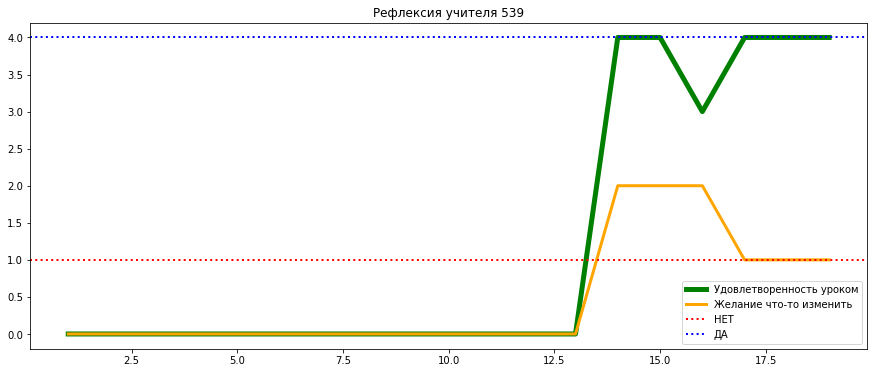

In [51]:
# Посмотрим эти параметры для некоторых организаций

plt.rcParams['figure.figsize'] = (15.0, 6)
plot_teacher_selfanalysis(539)


Комментарии учителя 697 к уроку:
1 Да, не считаю нужным что-то изменять. Для себя  ставлю цель больше работать с "середнячками", Есть понимание как это достичь
2 Да, увеличить количество взаимодействий с сильными учениками. Цель: перевести учащихся из слабой группы с в среднюю и далее.
3 Я не совсем удовлетворена уроком.  Среднее время пауз очень короткое, всего 2 секунды,  значит вопросы были  слишком лёгкими? С другой стороны тема урока - лёгкая, знакомая,интересная, затем практическая работа. Обсуждая протоколы на встрече мы пришли к выводу, что время на размышление и количество взаимодействий педагога с детьми зависит от содержания  урока, типа вопросов, готовности ученика к уроку, но уже начинают проявляться моменты, которые раньше не замечались. Нужно побратить внимание на типы вопросов для каждой из групп учеников.
4 Уроком удовлетворена частично. Пока не получается увеличить время ожидания, но удается себя контролировать во время урока.  Появилось понимание проблемы и направле

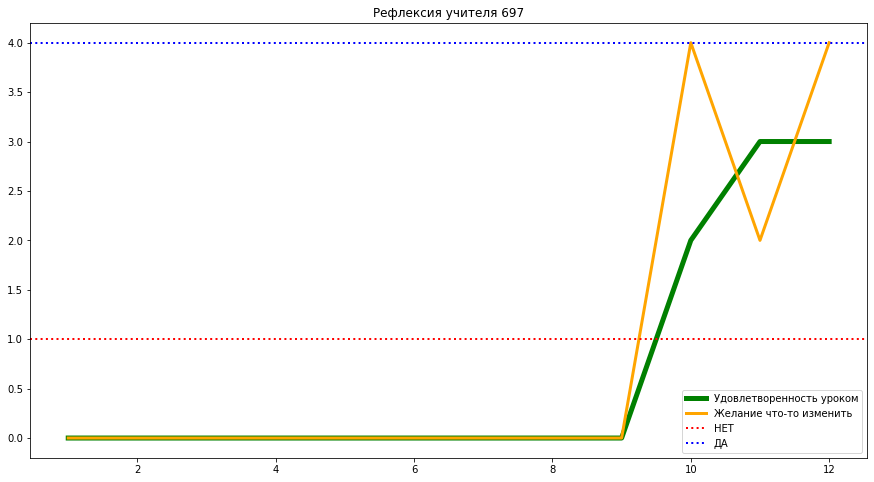

In [52]:
plt.rcParams['figure.figsize'] = (15.0, 8)
plot_teacher_selfanalysis(697)


Комментарии учителя 558 к уроку:
1 Цель урока, уделить внимание учащимся. Во время урока всем ученикам было распределено внимание учителя достаточновнимания. Каждому ученику было предоставлено время для ответа. Уроком удовлетворена в полном объеме.
2 Ведением урока удовлетворена в полной мере.Цель- взаимодействие и уделение внимание учителя классу.
3 Уроком удовлетворена. Дети активны, раскрепощены, свободны в выборе ответа .
4 Уроком удовлетворена, но я бы добавила несколько продуктивных вопросов. Цель для меня-добиться понимания темы, развитие мышления.
5 Цель: добиться понимания вопроса и полного развернутого ответа, на поставленный учителем вопрос.
6 Уроком удовлетворена, но не полностью. Слабые ученики  "отсиживаются". Для себя я  их стимулировала  репродуктивными вопросами  для понимания темы.
7 Уроком удовлетворена. Каких - либо изменений в урок не было внесено, всё было ясно и понятно.
8 Уроком удовлетворена. Для себя я  поставила давать детям вопросы продуктивного типа, чтобы

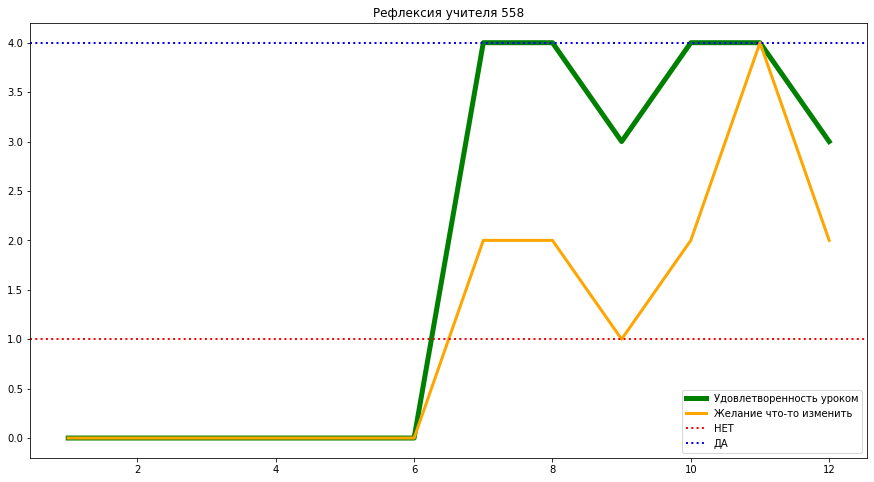

In [53]:
plot_teacher_selfanalysis(558)

#### Промежуточные выводы по анализу метрик учителей
- Данные по протоколам разных периодов не полные, поэтому по каждому учителю наблюдается выпадение данных, что лишает возможности полноценно рассматривать каждый из протоколов в ряду других. В этой связи для дальнейшего анализа кажется рациональным проводить сравнение параметров учителя в динамике весна-осень
- Паттерны метрик разных учителей очень отличаются. Тем не менее по диаграммам распределения параметров векторов взаимодействия и векторов внимания всех учителей проекта за весь год видно, что в среднем имеется некоторое смещение внимания учителя в сторону более сильных учеников несмотря на то, что задачи проекта подразумевали, что учителям было бы правильно научиться смещать внимание в сторону слабых.
- Идея сравнения векторов кажется перспективной, хотя вероятность случайных флуктуаций этих параметров из-за влияния параметров отдельного урока может быть значительной..
- Учитывая результаты анализа корреляций разных параметров, которые выявились при просмотре корреляционной матрицы, кажется перспективным попытаться восстановить параметры удовлетворенности и желания изменений по текстовым отчетам учителей. 
- Эти выводы учтем при формировании далее датафрейма для учителей

In [54]:
df_md.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3001 entries, 0 to 3000
Data columns (total 39 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   prot_id              3001 non-null   int64  
 1   template_code        3001 non-null   object 
 2   date_of_lesson       3001 non-null   object 
 3   org_id               3001 non-null   int64  
 4   teacher_id           3001 non-null   int64  
 5   observer_id          3001 non-null   int64  
 6   curator_id           3001 non-null   int64  
 7   class                872 non-null    float64
 8   satisfaction         1016 non-null   float64
 9   wish_to_change       952 non-null    float64
 10  pupils_all           3001 non-null   float64
 11  pupils_strong        2059 non-null   float64
 12  pupils_middle        2059 non-null   float64
 13  pupils_weak          2059 non-null   float64
 14  interactions_all     1845 non-null   float64
 15  interactions_strong  1818 non-null   f

___
<a id='organizations_dataframe_transformation' name='organizations_dataframe_transformation'></a>
## 5. Преобразование и анализ датафрейма с организациями
Возьмем за основу код из ноутбука с первичным анализом, а затем дополним его новыми колонками

In [55]:
# 
df_orgs = pd.DataFrame(df_md.groupby('org_id')['prot_id'].count())
df_orgs.insert(0, 'org_id', df_orgs.index)
df_orgs.columns = ['org_id', 'protocols']

def get_prot_level_count(o_id, level):
    return df_md[((df_md['org_id'] == o_id) & (df_md['level'] == level))]['prot_id'].count()

df_orgs['protocols_base'] = df_orgs.apply(lambda x: get_prot_level_count(x['org_id'], 1), axis=1)
df_orgs['protocols_complicated'] = df_orgs.apply(lambda x: get_prot_level_count(x['org_id'], 2), axis=1)
df_orgs['protocols_targeted'] = df_orgs.apply(lambda x: get_prot_level_count(x['org_id'], 3), axis=1)

#df_orgs['pupils_mean'] = df_orgs['pupils_mean'].round(0)

def get_unique_count(o_id, df_field):
    return len(df_md[df_md['org_id'] == o_id][df_field].unique())

df_orgs['curators'] = df_orgs.apply(lambda x: get_unique_count(x['org_id'], 'curator_id'), axis=1)
df_orgs['teachers'] = df_orgs.apply(lambda x: get_unique_count(x['org_id'], 'teacher_id'), axis=1)
df_orgs['prot_templates'] = df_orgs.apply(lambda x: get_unique_count(x['org_id'], 'template_code'), axis=1)

# Вычислим доп.параметр - количество протоколов на одного учителя в школе
df_orgs['protocols_per_teacher'] = (df_orgs['protocols']/df_orgs['teachers']).round(1)

df_orgs

,org_id,protocols,protocols_base,protocols_complicated,protocols_targeted,curators,teachers,prot_templates,protocols_per_teacher
org_id,,,,,,,,,
1,1,59,28,20,11,3,9,15,6.6
68,68,62,24,27,11,4,9,14,6.9
69,69,32,10,14,8,1,2,15,16.0
70,70,35,16,14,5,1,2,13,17.5
71,71,34,10,14,10,1,3,15,11.3
...,...,...,...,...,...,...,...,...,...
129,129,96,31,38,27,3,6,17,16.0
130,130,33,5,17,11,2,5,11,6.6
131,131,40,11,17,12,2,5,11,8.0


___
<a id='teachers_dataframe_transformation' name='teachers_dataframe_transformation'></a>
## 6. Преобразование и анализ датафрейма с учителями

1. Добавим колонки с